In [3]:
import numpy as np

c = np.array([1, 0, 0,0,0,0])
print("c: ",c)
W = np.random.randn(6, 3)
print("W: ",W)
h = np.matmul(c, W)
print("H",h)

c:  [1 0 0 0 0 0]
W:  [[-0.25847432  2.13916194  0.60877539]
 [ 0.79778516 -1.18898735  0.16699972]
 [-1.06732272 -0.91535072 -0.65333426]
 [ 0.51052677  1.21840615 -1.13441407]
 [ 0.9873397   0.29421083  1.17681261]
 [-0.3697269   0.06542768 -1.51541983]]
H [-0.25847432  2.13916194  0.60877539]


In [7]:
def preprocessing(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocessing(text)
print(corpus)
print(word_to_id)
print(id_to_word)            

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [6]:
import sys
sys.path.append('..')
from common.util import create_co_matrix, cos_similarity
import numpy as np
from common.layers import MatMul
from common.functions import softmax


c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

h0 = in_layer0.forward(c0)
print(h0)
h1 = in_layer1.forward(c1)
print(h1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)
print(softmax(s))


[[ 0.77994357 -0.67944557  1.34223407]]
[[ 0.01769344  0.42892935 -0.47254676]]
[[ 0.11366147 -0.02410778 -0.03290983  0.00565426 -0.67917384  0.68224035
   0.04311904]]
[[0.14743198 0.12845744 0.12733172 0.13233806 0.06672179 0.26032889
  0.13739012]]


7
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
7
5
[[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]]


/Users/seungwoo/anaconda3/envs/dust/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungwoo/anaconda3/envs/dust/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungwoo/anaconda3/envs/dust/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungwoo/anaconda3/envs/dust/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


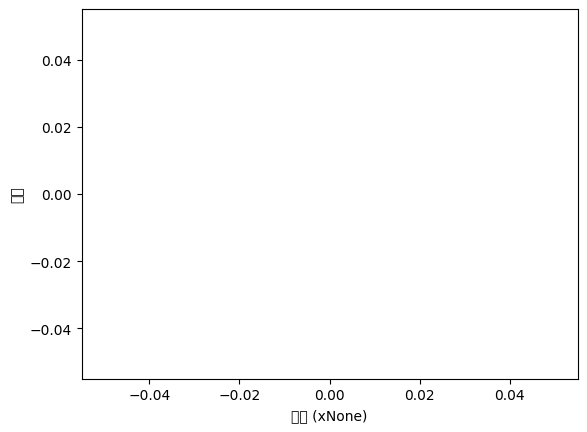

In [21]:
import sys
sys.path.append('..')
from common.layers import MatMul, SoftmaxWithLoss
from common.util import create_contexts_target, convert_one_hot
from common.trainer import Trainer
from common.optimizer import Adam
import numpy as np

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size) -> None:
        V, H = vocab_size, hidden_size
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        print(len(W_in))
        print(len(W_out))
        
        self.in_layers0 = MatMul(W_in)
        self.in_layers1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        layers = [self.in_layers0, self.in_layers1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h0 = self.in_layers0.forward(contexts[:, 0])
        h1 = self.in_layers1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        
        return loss
    
    def backward(self, dout = 1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layers1.backward(da)
        self.in_layers0.backward(da)
        return None
        
      
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocessing(text)

vocab_size = len(word_to_id)
print(vocab_size)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
print(target)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

print(contexts[:,0])
test = contexts[:,0]
# trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
# for word_id, word in id_to_word.items():
#     print(word, word_vecs[word_id])


word2vec 모델 종류 맞추기 문제 나온다.

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 26 |

/Users/seungwoo/anaconda3/envs/dust/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungwoo/anaconda3/envs/dust/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungwoo/anaconda3/envs/dust/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungwoo/anaconda3/envs/dust/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


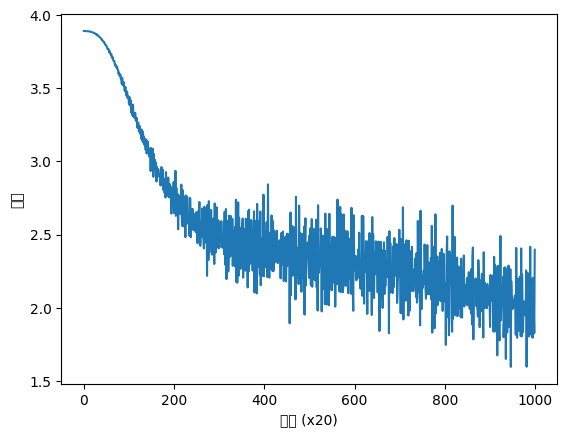

In [9]:
import sys
sys.path.append('..')
from common.layers import MatMul, SoftmaxWithLoss
from common.trainer import Trainer
from common.optimizer import Adam

class SimpleSkipGram:
    def __init__(self,vocab_size,hidden_size) -> None:
        V,H = vocab_size, hidden_size
        W_in = 0.01 * np.random.randn(V,H).astype('f')
        W_out = 0.01 * np.random.randn(H,V).astype('f')
        
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()
        
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss
    
    def backward(self, dout = 1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None
    
window_size = 1
hidden_size = 5
batch_size = 3

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocessing(text)
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleSkipGram(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)
trainer.fit(contexts, target, max_epoch, batch_size)    
trainer.plot()


